# Uso de teoria da informação para caracterização de redes

[<img src="https://upload.wikimedia.org/wikipedia/commons/c/c9/Webysther_20170627_-_Logo_ICMC-USP.svg">](https://upload.wikimedia.org/wikipedia/commons/c/c9/Webysther_20170627_-_Logo_ICMC-USP.svg)

+ Gabriel Lima Alves
+ Inara Yasmin
+ Jefter Santiago
+ Joey Gabriel dos Santos
+ João Francisco Arruda

# Conteúdo
 + Medidas de entropia e analise de componentes independentes
 + Classificando redes usando informação mútua
 + Ánalise dos resultados
 + Conclusão

# Bibliotecas utilizadas

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from math import log
from sklearn.decomposition import PCA
import time
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Entropia de Shannon

## Introdução

Tentamos usar entropia de Shannon para encontrar alguma correlação entre medidas em redes aleatórias. O objetivo inicial era entender se seria possível classificar redes de vários tipos a partir das medidas de entropia sob algumas distribuições de medidas de centralidade, conectividade, etc, feitas nas redes.

Para isso utilizamos a relação abaixo

$$ H(X) = \sum_{i} p(x) \log_{2} p(x) $$

com a entropia calculada em bits. Buscamos entender se a entropia de Shannon poderia fornecer capturar alguma propriedade inerente à algum tipo de rede, como por exemplo, ter uma medida de centralidade que apresenta alguma correlação para certo tipo de rede.

## Metodologia

Geramos redes aleatórias dos tipos estudadas no curso, `ER`, `WS` e `BA`, de diversas formas, fixando o número de nós ou grau ou até a razão entre esses dois. A partir da rede gerada calculamos algumas medidas de centralidade, conectividade etc, que foram transformadas em distribuições, já que queremos encontrar a entropia de Shannon associada às medidas.
Obtemos então o vetor
 $$ Y = [ H_{\text{k}}, H_{\text{EC}}, H_{\text{CC}}, H_{\text{BC}}, \dots ] $$

onde os termos são as entropias de cada medida para uma rede.

Após essa etapa, montamos uma matriz de correlação de medidas e tentamos visualizar essa correlação usando `PCA` e `ICA`.

## Implementação das medidas e resultados

In [ ]:
# Entropia de Shannon para uma distribuição.
def ShannonEntropy(dist):
  H = 0
  for p in dist:
    if(p>0):
      H -= + p*np.log2(p)
  return H

In [ ]:
def calcular_medidas(G):
    medidas = []

    # Grau de cada nó
    graus = np.array(list(dict(G.degree(G)).values()))
    graus, _ = np.histogram(graus, bins=10)
    medidas.append(graus)

    # Eigenvector Centrality
    eigenvector_centrality = np.array(list(dict(nx.eigenvector_centrality(G)).values()))
    eigenvector_centrality, _ = np.histogram(eigenvector_centrality, bins=10)
    eigenvector_centrality = eigenvector_centrality/sum(eigenvector_centrality)
    medidas.append(eigenvector_centrality)

    # Betweenness Centrality
    betweenness_centrality = np.array(list(dict(nx.betweenness_centrality(G)).values()))
    betweenness_centrality, _ = np.histogram(betweenness_centrality, bins=10)
    betweenness_centrality = betweenness_centrality/sum(betweenness_centrality)
    medidas.append(betweenness_centrality)

    # Closeness Centrality
    closeness_centrality = np.array(list(dict(nx.closeness_centrality(G)).values()))
    closeness_centrality, _ = np.histogram(closeness_centrality, bins=10)
    closeness_centrality = closeness_centrality/sum(closeness_centrality)
    medidas.append(closeness_centrality)

    # PageRank
    pagerank = np.array(list(dict(nx.pagerank(G)).values()))
    pagerank, _ = np.histogram(pagerank, bins=10)
    pagerank = pagerank/sum(pagerank)
    medidas.append(pagerank)

    # Clustering
    clustering = np.array(list(dict(nx.clustering(G)).values()))
    clustering, _ = np.histogram(clustering, bins=10)
    clustering = clustering/sum(clustering)
    medidas.append(clustering)

    return medidas

In [ ]:
def data_panda(x,y):
    data = pd.DataFrame(x)
    d_y = pd.DataFrame(y)
    return data

In [ ]:
def matriz_corr(data):
    # obtem a matriz de correlação dos dados
    corr = data.corr()
    # Mostra a matriz
    plt.figure(figsize=(7, 7))
    # imshow é usado para mostrar imagens
    plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
    # mostra a barra lateral de cores
    plt.colorbar()
    # inclui o nome das variáveis
    plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr)), corr.columns);
    plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
    plt.grid(False)
    plt.show()

    p = 0.75 # correlação mínima
    var = []
    for i in corr.columns:
        for j in corr.columns:
            if(i != j):
                if np.abs(corr[i][j]) > p: # se maior do que |p|
                    var.append([i,j])
    print('Variáveis mais correlacionadas:\n', var)

In [ ]:
def data_pca(data):
    # Instanciar objeto PCA
    pca = PCA(n_components=2)

    # Aplicar PCA ao DataFrame
    data_PCA = pca.fit_transform(data)

    # Converter os resultados para um novo DataFrame
    data_PCA = pd.DataFrame(data_PCA)

    # Exibir o DataFrame transformado
    return data_PCA

In [ ]:
def grafico_pca(data_PCA,y):
    # Separar os dados em colunas
    eixo_x = data_PCA[0]
    eixo_y = data_PCA[1]
    colors = y

    plt.title("PCA", fontsize = 22)
    # Definir rótulos dos eixos
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    colors = y

    # Mapear os valores numéricos para cores
    color_map = {0.0: 'red', 1.0: 'blue', 2.0: 'green'}
    color_labels = [color_map[val] for val in colors]

    # Criar o gráfico de dispersão
    plt.scatter(eixo_x, eixo_y, c=color_labels)

    # Criar a legenda das cores
    unique_values = np.unique(colors)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[val], label=val) for val in unique_values]
    plt.legend(handles=legend_elements, title='Valores')

    # Exibir o gráfico
    plt.show()

In [ ]:
def data_ica(data):
    from sklearn.decomposition import FastICA

    # Instanciar objeto ICA
    ica = FastICA(n_components=2)

    # Aplicar ICA ao DataFrame
    data_ICA = ica.fit_transform(data)

    # Converter os resultados para um novo DataFrame
    data_ICA = pd.DataFrame(data_ICA)

    # Exibir o DataFrame transformado
    return data_ICA

In [ ]:
def grafico_ica(data_ICA,y):
    # Separar os dados em colunas
    eixo_x = data_ICA[0]
    eixo_y = data_ICA[1]
    colors = y


    plt.title("ICA", fontsize = 22)
   # Definir rótulos dos eixos
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    colors = y

    # Mapear os valores numéricos para cores
    color_map = {0.0: 'red', 1.0: 'blue', 2.0: 'green'}
    color_labels = [color_map[val] for val in colors]

    # Criar o gráfico de dispersão
    plt.scatter(eixo_x, eixo_y, c=color_labels)

    # Criar a legenda das cores
    unique_values = np.unique(colors)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[val], label=val) for val in unique_values]
    plt.legend(handles=legend_elements, title='Valores', fontsize = 16)

    # Exibir o gráfico
    plt.show()

In [ ]:
def gerar_redes(x, y, Ns, Ks, n_nets):

    for i in range(0,n_nets):
        start_time = time.time()
        k1 = Ks[i]
        N = Ns[i]
        av_degree = k1

        #ER networks
        p = av_degree/(N-1)
    #for i in range(0,n_nets):
        GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        aux = calcular_medidas(GER)
        x.append([ShannonEntropy(z) for z in aux])
        y.append(0.0)

        #WS networks
        k = int(av_degree)
        p = 0.1 #probability of rewiring
    #for i in range(0,n_nets):
        GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
        Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
        GWS = GWS.subgraph(Gcc[0])
        GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        aux = calcular_medidas(GWS)
        x.append([ShannonEntropy(z) for z in aux])
        y.append(1.0)

        # BA networks
        m = int(av_degree/2)
    #for i in range(0,n_nets):
        GBA = nx.barabasi_albert_graph(N, m)
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        aux = calcular_medidas(GBA)
        x.append([ShannonEntropy(z) for z in aux])
        y.append(2.0)

        end_time = time.time()
        print(i, N, k1, end_time - start_time)

## Resultados

Inicialmente realizamos as medidas e armazenamos em arquivos que lemos nesse notebook para fazer as ánalises.Isso porque realizar as medidas em redes rapidamente ficava impraticavel em questão de tempo de processamento.


### Razão entre grau e número de nós constante

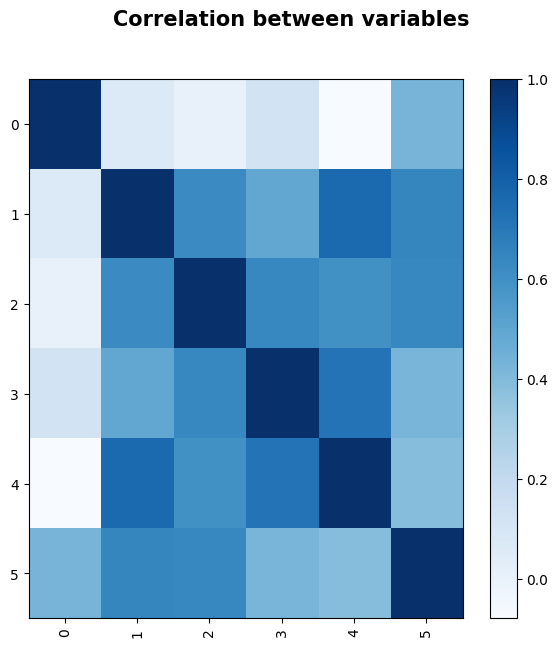

Variáveis mais correlacionadas:
 [[1, 4], [4, 1]]


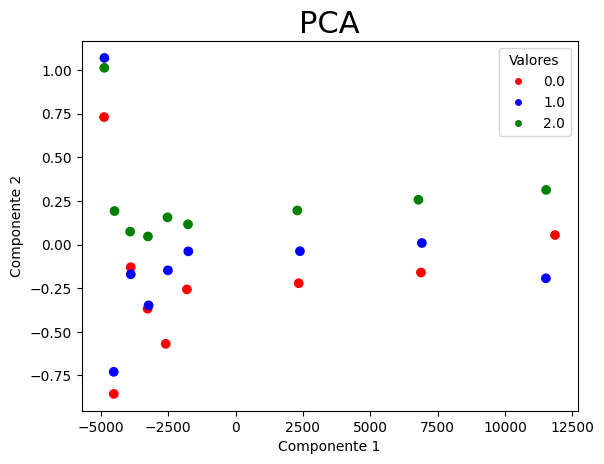

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


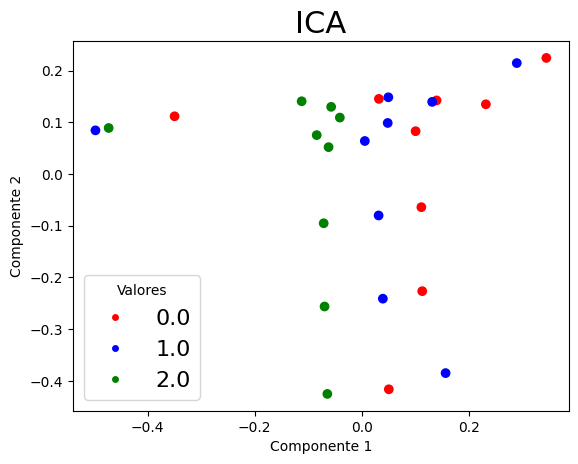

In [ ]:
x = []
y = []

x = np.load('/content/drive/MyDrive/Redes Complexas - Trabalho/Final/dados/caso1_x.npy')
y = np.load('/content/drive/MyDrive/Redes Complexas - Trabalho/Final/dados/caso1_y.npy')

"""Ns = [10,100,200,300,400,500,1000,1500,2000]
Ns = np.array(Ns)
Ks = Ns/2
Ks = np.array(Ks)
n_nets = 9

gerar_redes(x, y, Ns, Ks, n_nets)"""

x = np.array(x)
y = np.array(y)

np.save('caso1_x.npy', x)
np.save('caso1_y.npy', y)

data = data_panda(x,y)
matriz_corr(data)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)
data_ICA = data_ica(data)
grafico_ica(data_ICA,y)

### Grau constante

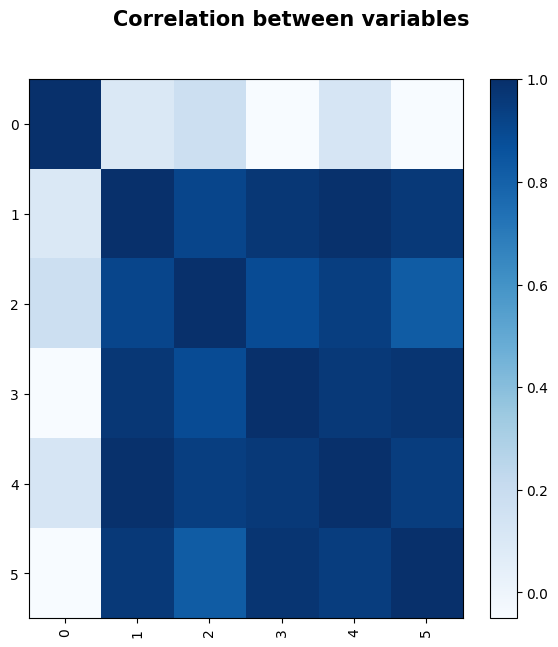

Variáveis mais correlacionadas:
 [[1, 2], [1, 3], [1, 4], [1, 5], [2, 1], [2, 3], [2, 4], [2, 5], [3, 1], [3, 2], [3, 4], [3, 5], [4, 1], [4, 2], [4, 3], [4, 5], [5, 1], [5, 2], [5, 3], [5, 4]]


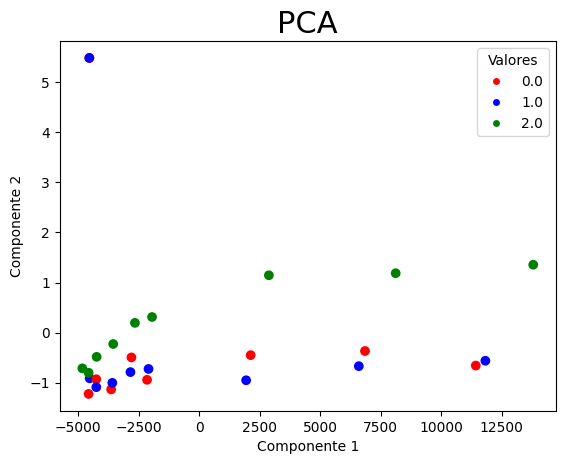

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


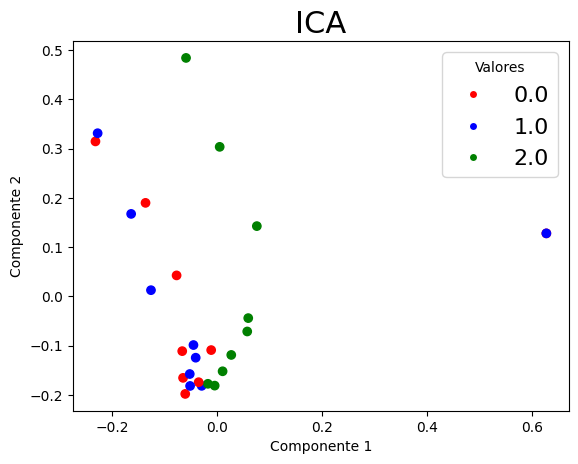

In [ ]:
x = []
y = []

x = np.load('/content/drive/MyDrive/Redes Complexas - Trabalho/Final/dados/caso2_x.npy')
y = np.load('/content/drive/MyDrive/Redes Complexas - Trabalho/Final/dados/caso2_y.npy')

"""Ns = [100,150,200,300,400,500,1000,1500,2000]
Ns = np.array(Ns)
Ks = [100]*9
Ks = np.array(Ks)
n_nets = 9

gerar_redes(x, y, Ns, Ks, n_nets)"""

x = np.array(x)
y = np.array(y)

np.save('caso2_x.npy', x)
np.save('caso2_y.npy', y)

data = data_panda(x,y)
matriz_corr(data)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)
data_ICA = data_ica(data)
grafico_ica(data_ICA,y)

### Número de nós constante

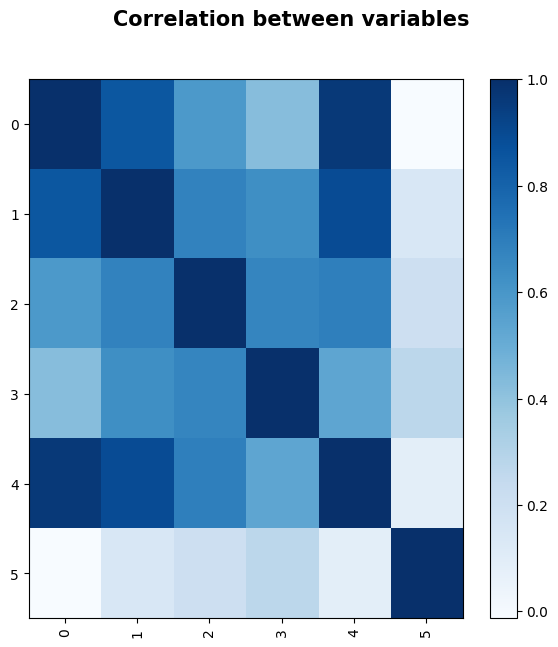

Variáveis mais correlacionadas:
 [[0, 1], [0, 4], [1, 0], [1, 4], [4, 0], [4, 1]]


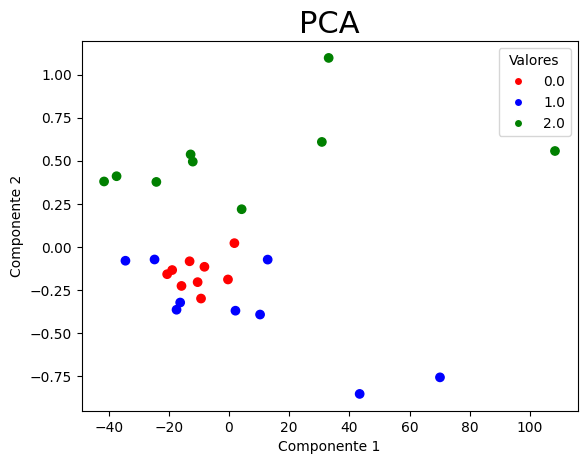

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


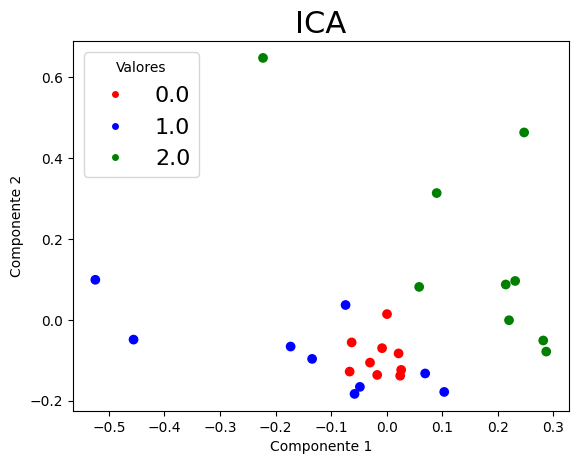

In [ ]:
x = []
y = []


x = np.load('/content/drive/MyDrive/Redes Complexas - Trabalho/Final/dados/caso3_x.npy')
y = np.load('/content/drive/MyDrive/Redes Complexas - Trabalho/Final/dados/caso3_y.npy')

"""Ns = [100]*9
Ns = np.array(Ns)
Ks = [10,20,30,40,50,60,70,80,90]
Ks = np.array(Ks)
n_nets = 9

gerar_redes(x, y, Ns, Ks, n_nets)"""

x = np.array(x)
y = np.array(y)

np.save('caso3_x.npy', x)
np.save('caso3_y.npy', y)

data = data_panda(x,y)
matriz_corr(data)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)
data_ICA = data_ica(data)
grafico_ica(data_ICA,y)

Como podemos ver pelos gráficos do `PCA` e `ICA`, a medida de entropia sozinha não é capaz de fornecer alguma correlação entre os tipos de redes.

# Informação mútua

## Introdução

Usaremos a seguir conceitos de informação mútua para a classificação de redes complexas. A ideia é, assim como na parte anterior, utilizarmos diferentes medidas como valor do grau, eigenvector centrality, entre outros para entender como tipos diferentes de redes podem ser classificados a partir das relações entre essas medidas. Talvez redes do tipo BA tenham uma relação do grau com betweenness centrality pouco dependente, mas em comparação com redes do tipo ER, por exemplo, essas medidas sejam mais relacionadas.

Durante o curso vimos como variáveis podem mostrar relações usando correlações entre as medidas, como a de Pearson ou a de Spearman. Esses coeficientes mostram como uma medida se comporta com base no comportamento de uma outra, mas geralmente essas correlações medem dependências lineares, enquanto que a Informação Mútua tem um carater mais generalista, sendo mais sensível a diferentes tipos de dependência, até mesmo não linear.

## Cálculo da Informação Mútua

\begin{align}
        \mathbf{I} (X, Y) = \sum_{x \in X} \sum_{y \in Y} p(x, y) \cdot \log_2\left [\frac{p(x, y)}{p(x)p(y)}\right]
\end{align}

Onde $p(x, y)$ é a probabilidade de ocorrência simultânea e $p(x)$ e $p(y)$ são as probabilidades de ocorrência de cada variável. Para o caso de distribuições contínuas de probabilidade, substituiremos o somatório por uma integral. Usando o logaritmo de base 2, a unidade da informação mútua será bits, mas podemos usar valores de $e$ ou 10 para a base, assim a unidade será nat ou hartley, respectivamente. Neste trabalho usaremos $e$ como base, resultando assim em unidades de medida em nats.


Podemos perceber que para o caso de independência completa entre as medidas, ou seja, $p(x, y) = p(x)p(y)$, portanto $\mathbf{I}(X,Y) = 0$, naturalmente, quanto maior a dependencia entre as variáveis maior o valor que irá retornar em $\mathbf{I}(X,Y)$.


Pelo próprio cálculo, podemos ver semelhanças entre informação mútua e entropia, o que não é coincidência. Entropia é uma medida que retorna a quantidade de incerteza daquela variável, o valor da informação mútua não é diferente, ele demonstra o grau de incerteza de uma certa variável com base no que conhecemos de outra. Ou seja, quão bem conseguimos descobrir uma informação sobre Y, dado que descobrimos que há uma alta dependência dele com X, com base na informação mútua? Se forem altamente dependentes, Y terá uma menor incerteza dado nosso conhecimento sobre X.

## Metodologia

A partir das medidas das redes descobrimos seu grau de dependência entre si, usando a informação mútua (cálculo acima) para alimentarmos um classificador e assim tentamos descobrir se há um comportamento entre as medidas exclusivo de determinado **tipo de rede**.  Destaco o uso das bibliotecas NetworkX, para a extração dos valores dessas medidas e o uso do sklearn para o cálculo da informação mútua. Guardaremos esses valores em um DataFrame utilizando Pandas e enfim usaremos um classificador para a análise dos resultados.

Cada rede será gerada aleatoriamente composta por 100 nós com graus médios diferentes. Serão 7 redes de cada tipo ER, WS e BA, com graus médio variando de 10 a 70.

## Implementação e resultados

In [ ]:
def calcular_medidas(G):

    # Grau de cada nó 0
    graus = np.array(list(dict(G.degree(G)).values()))
    N = int(len(graus)/2)
    df = pd.DataFrame({"Graus":graus})

    # Eigenvector Centrality 1
    eigenvector_centrality = np.array(list(dict(nx.eigenvector_centrality(G)).values()))

    # Betweenness Centrality 2
    betweenness_centrality = np.array(list(dict(nx.betweenness_centrality(G)).values()))

    # Closeness Centrality 3
    closeness_centrality = np.array(list(dict(nx.closeness_centrality(G)).values()))

    # PageRank 4
    pagerank = np.array(list(dict(nx.pagerank(G)).values()))

    # Clustering 5
    clustering = np.array(list(dict(nx.clustering(G)).values()))

    # Salvamos todas as medidas em um DataFrame do Pandas
    #        para melhorar o manuseio das informações

    df['Eigenvector Centrality'] = eigenvector_centrality
    df['Betweenness Centrality'] = betweenness_centrality
    df['Closeness Centrality'] = closeness_centrality
    df['Pagerank'] = pagerank
    df['Clustering'] = clustering
    return df

In [ ]:
cl = ['ER','WS','BA']
x = {"eigen": [], "between": [], "close": [], "pagerank": [], "clustering": []}

Ns = [100]*10
Ns = np.array(Ns)
Ks = [10,20,30,40,50,60,70,80,90,100]
Ks = np.array(Ks)
n_nets = 7

for i in range(0,n_nets):
    start_time = time.time()
    k1 = Ks[i]
    N = Ns[i]
    av_degree = k1

    #ER networks
    p = av_degree/(N-1)

    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    aux = calcular_medidas(GER)
    x["eigen"].append(mutual_info_regression(aux['Eigenvector Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["between"].append(mutual_info_regression(aux['Betweenness Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["close"].append(mutual_info_regression(aux['Closeness Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["pagerank"].append(mutual_info_regression(aux['Pagerank'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["clustering"].append(mutual_info_regression(aux['Clustering'].to_frame(), aux['Graus'], discrete_features=False)[0])

    #WS networks
    k = int(av_degree)
    p = 0.1 #probabilidade de rewiring

    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    aux = calcular_medidas(GWS)
    x["eigen"].append(mutual_info_regression(aux['Eigenvector Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["between"].append(mutual_info_regression(aux['Betweenness Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["close"].append(mutual_info_regression(aux['Closeness Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["pagerank"].append(mutual_info_regression(aux['Pagerank'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["clustering"].append(mutual_info_regression(aux['Clustering'].to_frame(), aux['Graus'], discrete_features=False)[0])

    # BA networks
    m = int(av_degree/2)

    GBA = nx.barabasi_albert_graph(N, m)
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    aux = calcular_medidas(GBA)
    x["eigen"].append(mutual_info_regression(aux['Eigenvector Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["between"].append(mutual_info_regression(aux['Betweenness Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["close"].append(mutual_info_regression(aux['Closeness Centrality'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["pagerank"].append(mutual_info_regression(aux['Pagerank'].to_frame(), aux['Graus'], discrete_features=False)[0])
    x["clustering"].append(mutual_info_regression(aux['Clustering'].to_frame(), aux['Graus'], discrete_features=False)[0])

    print(i, N, k1)

0 100 10
1 100 20
2 100 30
3 100 40
4 100 50
5 100 60
6 100 70


In [ ]:
dados = pd.DataFrame(x)

print(np.std(dados["eigen"]))
print(np.std(dados["between"]))
print(np.std(dados["close"]))
print(np.std(dados["pagerank"]))
print(np.std(dados["clustering"]))

dados = dados.drop(columns=['clustering'])

0.5321472308677218
0.47014537702362746
0.864667086404434
0.43383644949386585
0.18965056940897757


In [ ]:
from sklearn.decomposition import FastICA
# Instanciar objeto ICA
ica = FastICA(n_components=2)

# Aplicar ICA ao DataFrame
data_ICA = ica.fit_transform(dados)

# Converter os resultados para um novo DataFrame
data_ICA = pd.DataFrame(data_ICA)

# Exibir o DataFrame transformado
data_ICA

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


,0,1
0,-0.287809,-0.187389
1,-0.392595,0.285324
2,-0.454907,-0.292076
3,-0.124652,-0.201773
4,-0.309970,0.327020
5,-0.177643,-0.168704
6,0.093121,-0.075932
7,-0.246728,0.275840
8,0.040226,-0.146483
9,0.155662,-0.035680


In [ ]:
kmeans = SpectralClustering(n_clusters=2, assign_labels='discretize').fit(data_ICA)
labels = kmeans.labels_

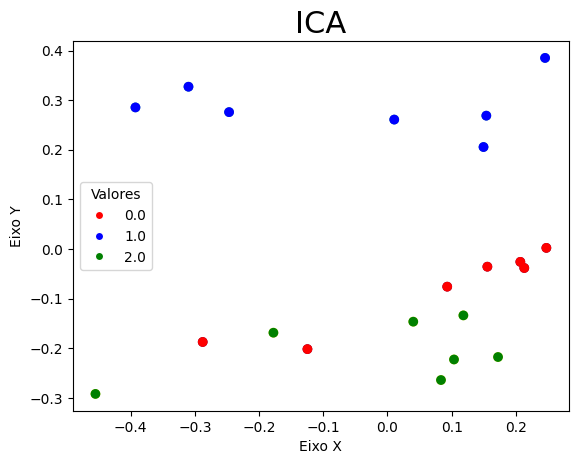

In [ ]:
# Separar os dados em colunas
eixo_x = data_ICA[0]
eixo_y = data_ICA[1]
y = 7*[0.0, 1.0, 2.0]
colors = y

#print(eixo_x, eixo_y, y)

# Criar o gráfico de dispersão
plt.scatter(eixo_x, eixo_y, c=colors)
plt.title("ICA", fontsize = 22)
# Definir rótulos dos eixos
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')

# Mapear os valores numéricos para cores
color_map = {0.0: 'red', 1.0: 'blue', 2.0: 'green'}
color_labels = [color_map[val] for val in colors]

# Criar o gráfico de dispersão
plt.scatter(eixo_x, eixo_y, c=color_labels)

# Criar a legenda das cores
unique_values = np.unique(colors)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[val], label=val) for val in unique_values]
plt.legend(handles=legend_elements, title='Valores')

# Exibir o gráfico
plt.show()

In [ ]:
cl = ['ER','WS','BA']
x = {"eigen": [], "degree": [], "close": [], "pagerank": [], "clustering": []}

Ns = [100]*10
Ns = np.array(Ns)
Ks = [10,20,30,40,50,60,70,80,90,100]
Ks = np.array(Ks)
n_nets = 7

for i in range(0,n_nets):
    start_time = time.time()
    k1 = Ks[i]
    N = Ns[i]
    av_degree = k1

    #ER networks
    p = av_degree/(N-1)

    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    aux = calcular_medidas(GER)
    x["eigen"].append(mutual_info_regression(aux['Eigenvector Centrality'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["degree"].append(mutual_info_regression(aux['Graus'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["close"].append(mutual_info_regression(aux['Closeness Centrality'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["pagerank"].append(mutual_info_regression(aux['Pagerank'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["clustering"].append(mutual_info_regression(aux['Clustering'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])

    #WS networks
    k = int(av_degree)
    p = 0.1 #probabilidade de rewiring

    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    aux = calcular_medidas(GWS)
    x["eigen"].append(mutual_info_regression(aux['Eigenvector Centrality'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["degree"].append(mutual_info_regression(aux['Graus'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["close"].append(mutual_info_regression(aux['Closeness Centrality'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["pagerank"].append(mutual_info_regression(aux['Pagerank'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["clustering"].append(mutual_info_regression(aux['Clustering'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])

    # BA networks
    m = int(av_degree/2)

    GBA = nx.barabasi_albert_graph(N, m)
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    aux = calcular_medidas(GBA)
    x["eigen"].append(mutual_info_regression(aux['Eigenvector Centrality'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["degree"].append(mutual_info_regression(aux['Graus'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["close"].append(mutual_info_regression(aux['Closeness Centrality'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["pagerank"].append(mutual_info_regression(aux['Pagerank'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])
    x["clustering"].append(mutual_info_regression(aux['Clustering'].to_frame(), aux['Betweenness Centrality'], discrete_features=False)[0])

    print(i, N, k1)


0 100 10
1 100 20
2 100 30
3 100 40
4 100 50
5 100 60
6 100 70


In [ ]:
dados = pd.DataFrame(x)
# Instanciar objeto PCA
pca = FastICA(n_components=2)

# Aplicar PCA ao DataFrame
data_PCA = pca.fit_transform(dados)

# Converter os resultados para um novo DataFrame
data_PCA = pd.DataFrame(data_PCA)

# Exibir o DataFrame transformado
data_PCA

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


,0,1
0,-0.138656,-0.104710
1,-0.282752,0.280096
2,0.070403,0.053144
3,-0.166514,-0.218120
4,0.083406,0.417442
5,-0.100354,-0.162137
6,-0.118047,-0.274331
7,-0.247617,0.312363
8,-0.150653,-0.143340
9,-0.055064,-0.305129


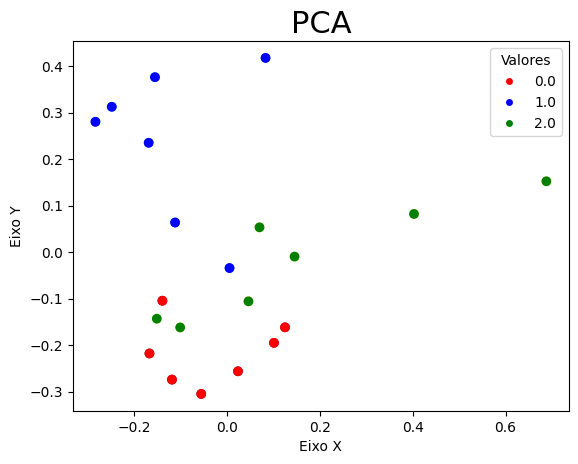

In [ ]:
# Separar os dados em colunas
eixo_x = data_PCA[0]
eixo_y = data_PCA[1]
y = 7*[0.0, 1.0, 2.0]
colors = y

#print(eixo_x, eixo_y, y)

# Criar o gráfico de dispersão
plt.scatter(eixo_x, eixo_y, c=colors)

plt.title("PCA", fontsize = 22)
# Definir rótulos dos eixos
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')

# Mapear os valores numéricos para cores
color_map = {0.0: 'red', 1.0: 'blue', 2.0: 'green'}
color_labels = [color_map[val] for val in colors]

# Criar o gráfico de dispersão
plt.scatter(eixo_x, eixo_y, c=color_labels)

# Criar a legenda das cores
unique_values = np.unique(colors)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[val], label=val) for val in unique_values]
plt.legend(handles=legend_elements, title='Valores')

# Exibir o gráfico
plt.show()

Pelos gráficos, entendemos que a informação mútua calculada fornecer correlações entre os tipos de rede para as várias medidas utilizadas.

# Conclusão

Com base nos resultados obtidos em nosso estudo sobre a caracterização de redes complexas usando teoria da informação, podemos concluir que a entropia de Shannon das medidas em redes, como centralidade e conectividade, não foi suficiente para classificar, separar ou entender essas redes e seus tipos. Realizamos uma análise de PCA e ICA sobre esses resultados, mas não encontramos nenhuma correlação significativa.

É importante ressaltar que geramos redes aleatórias com diferentes restrições, fixando o grau ou a quantidade de nós, bem como a razão entre esses valores. No entanto, em nenhum dos casos encontramos uma correlação entre a entropia de Shannon e os tipos de redes estudados.




Na segunda parte do estudo, exploramos a informação mútua como uma medida alternativa. Realizamos as mesmas medidas nas redes e calculamos a informação mútua com base nelas. Observamos que a informação mútua foi capaz de fornecer alguma correlação entre os tipos de medida, ou seja, foi capaz de capturar as relações entre as diferentes características das redes. Em especial, na nossa comparação, usando redes do tipo ER, WS e BA, as redes do tipo WS se destacaram mais e fomos capazes de separar suas medidas utilizando um método de clusterização (Spectral Clustering), enquanto que, ainda que visualmente possamos perceber certos padrões separando as medidas dos tipos ER e BA, o processo de clusterização se mostrou menos eficiente com estas.

Ainda assim, esses resultados indicam que a informação mútua pode ser uma abordagem mais adequada para a caracterização e classificação de redes complexas. A capacidade da informação mútua de capturar as relações entre as medidas nos permite obter insights mais precisos sobre a estrutura e organização dessas redes. Portanto, seu uso pode ser promissor para futuros estudos e aplicações na área de redes complexas e teoria da informação.




